In [1]:
from sklearn import svm
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [2]:
#General Imports
import csv
import math
import matplotlib.pyplot as plt
import pylab as pl

#ScikitLearn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split

#Qiskit imports
from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [3]:
# Constants
SEED = 2508

In [4]:
from qiskit import IBMQ
from qiskit.visualization import plot_error_map

In [5]:
# IBMQ.save_account('YOUR TOKEN HERE')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education',group='qscitech-quantum',project='qc-bc-workshop')

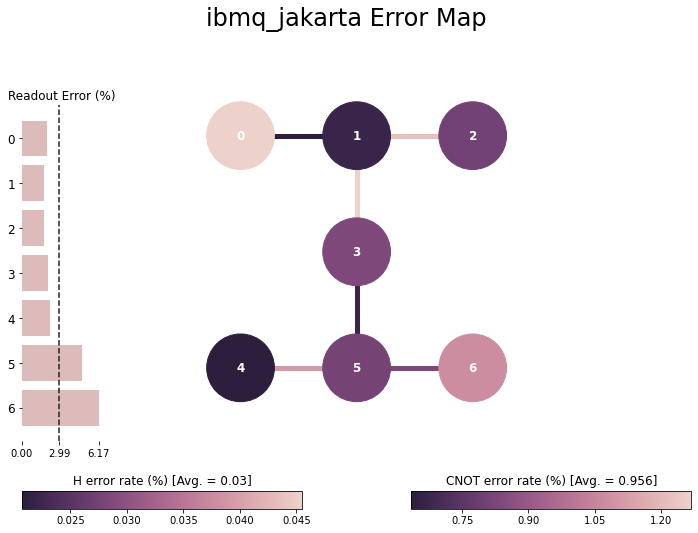

In [6]:
ibmq_jakarta = provider.get_backend('ibmq_jakarta')
plot_error_map(ibmq_jakarta)

In [229]:
# 0. Prepare Dataset (legacy, no longer in use)

In [228]:
# **Dataset Information:**
# * Total examples: 1372 -- Dimensions: 5
# * Training set [to train a model]: 
# * (Validation set [to benchmark different models and choose the best performer]):
# * Test set [to test actual performance of the best performer following validation]:

In [219]:
# datafile = pd.read_csv("data_banknote_authentication.txt",header=0)
# datafile

In [220]:
# data = datafile.to_numpy()
# print(f'{data.shape} -- {data.shape[0]} examples ; {data.shape[1] - 1} features')
# TODO: split the dataset to: Training set (100 points only), (Validation set), Test set
# TODO: might need to scale (or, normalize) the features -- explanation: in gradient-based ML, we want all features to be
# at the same scale (e.g., all between [-1,1]) to optimize learning performance.
# Here, we have features 1 and 2 can have value upto +/-20, which is very large compared to other features --> need scaling

In [221]:
# datafile_100 = pd.read_csv("Datasets/fraud_detection_bank_dataset.csv")
# datafile_100

In [222]:
# data_100 = datafile_100.to_numpy()
# print(f'{data_100.shape} -- {data_100.shape[0]} examples ; {data_100.shape[1]-1} features')

In [223]:
# xdata_100, ydata_100 = np.hsplit(data_100, [4])
# feature_dim=np.shape(xdata_100)[1]
# print(f'{feature_dim} number of features')
# xdata_100
# ydata_100
# print(f'{xdata_100.shape} -- {ydata_100.shape}')

In [224]:
# test_ratio=0.9
# seed=2456

In [225]:
# x_train, x_test, y_train, y_test = train_test_split(xdata_100, ydata_100, test_size=test_ratio, random_state=seed)
# # x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])
# # x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test])
# print(f'{x_train.shape} -- {y_train.shape}')
# print(f'{x_test.shape} -- {y_test.shape}')
# #x_train[4]
# print(y_train[4])
# y_train = np.reshape(y_train, -1).astype(int)
# print(y_train[1])
# y_test = np.reshape(y_test, -1).astype(int)
# #print(x_train[4])

In [226]:
# y_train

# 1. Prepare (New) Dataset

**Dataset Information:**
* Total examples: 20,468 -- Dimensions: 112
* PCA down to: **4** dimensions
* Train set size: **100 (adjustable in cell below)**
* Test set size: **2,000 (adjustable in cell below)**

**Variables Information:**
* `x_train` [np.array] stores the train examples -- shape: (Train set size, 4)
* `y_train` [np.array] stores the train labels -- shape: (Train set size,)
* `x_test` [np.array] stores the test examples -- shape: (Test set size, 4)
* `y_test` [np.array] stores the train labels -- shape: (Test set size,)

**Note:** Run all cells in this section to generate the dataset variables

In [4]:
# set number of training and test example ---------------
n_examples = 100
n_test = 2000
# -------------------------------------------------------

In [5]:
# change the directory to the correct one on your machine
datafile = pd.read_csv("fraud_detection_bank_dataset.txt")
data = datafile.to_numpy()
datafile

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,9,1354,0,18,0,1,7,9,0,0,...,0,0,0,1,1,0,0,0,49,1
1,0,239,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,55,1
2,0,260,0,4,0,3,6,0,0,0,...,0,0,0,1,1,0,0,0,56,1
3,17,682,0,1,0,0,8,17,0,0,...,0,1,0,1,1,0,0,0,65,1
4,1,540,0,2,0,1,7,1,0,0,...,0,0,0,1,1,0,0,0,175,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20463,0,88,0,0,0,2,-1,0,0,0,...,0,1,0,0,0,0,1,0,85,0
20464,0,134,0,2,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,7,0
20465,4,393,1,1,0,0,-1,4,0,0,...,0,1,0,0,0,0,0,0,45,0
20466,0,10,0,1,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,0,5,0


In [6]:
from sklearn import preprocessing
# Scale the features in the dataset, prior to PCA
X_data = data[:,:-1]
X_data = preprocessing.StandardScaler().fit_transform(X_data)

In [7]:
# PCA to reduce the number of features
pca = PCA(n_components=4,random_state=SEED)
X_pca = pca.fit_transform(X_data)
# Scale the features in the dataset, post PCA
X_pca = preprocessing.StandardScaler().fit_transform(X_pca)

In [8]:
import random
n_class_train = int(n_examples/2)
n_class_test = int(n_test/2)

# Randomly samples the training set for both classes
random.seed(SEED)

# 0 --> 3000 (pos train) ; 3000 --> 5438 (pos test)
# 5438 --> 18000 (neg train) ; 18000 --> 20468 (neg test)
rand_pos_ind = random.sample(range(0, 3000), n_class_train)
rand_neg_ind = random.sample(range(5438, 18000), n_class_train)
x_train = np.concatenate((X_pca[rand_pos_ind],X_pca[rand_neg_ind]))
y_train = np.concatenate((np.ones((n_class_train,1)),np.zeros((n_class_train,1)))).astype(int).reshape(n_examples,)

rand_pos_ind = random.sample(range(3000, 5438), n_class_test)
rand_neg_ind = random.sample(range(18000, 20468), n_class_test)
x_test = np.concatenate((X_pca[rand_pos_ind],X_pca[rand_neg_ind]))
y_test = np.concatenate((np.ones((n_class_test,1)),np.zeros((n_class_test,1)))).astype(int).reshape(n_test,)

# compatibility with previous implementation
x_train_norm = x_train
x_test_norm = x_test

# 2. VQC from scratch

## 2.1. Prepare encoders and ansatz

In [9]:
import matplotlib.pyplot as plt

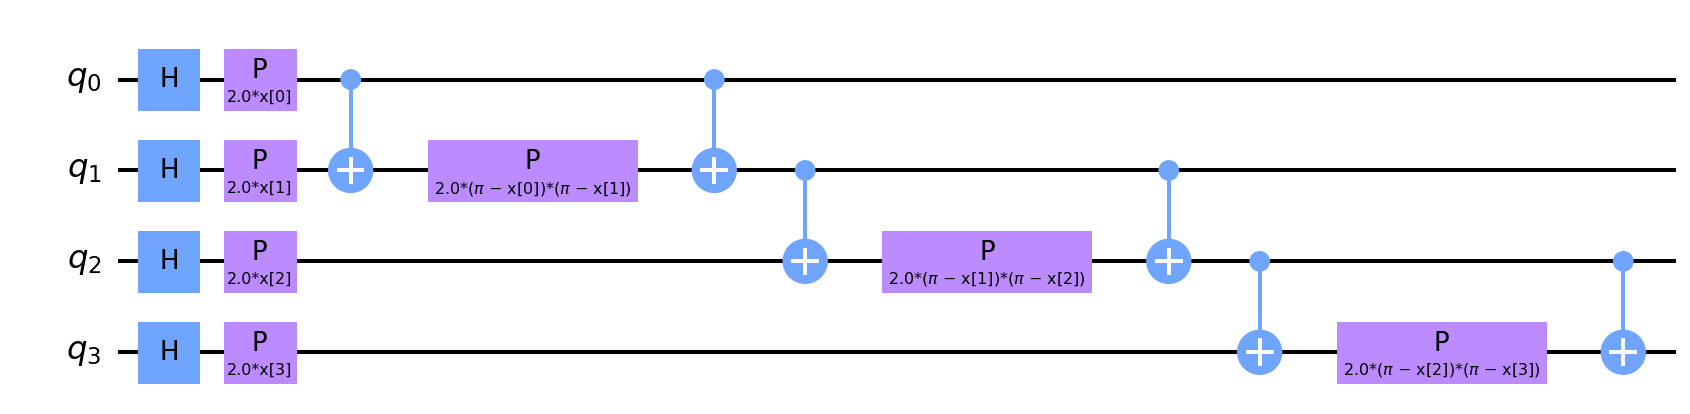

In [18]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(feature_dim, 1, 'linear')
fmap_zz.decompose().draw('mpl', scale=2)

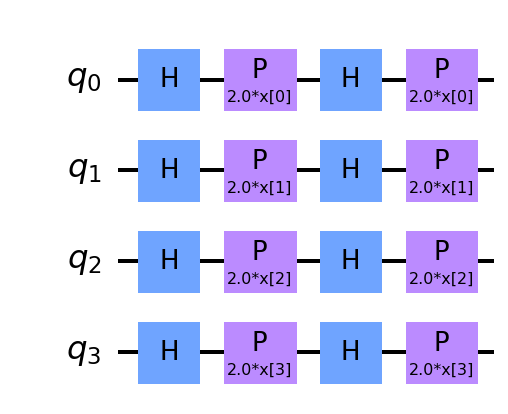

In [19]:
def get_z_feature_map(feature_dim, feature_map_rep):
    return ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep)

fmap_z = get_z_feature_map(feature_dim, 2)
fmap_z.decompose().draw('mpl', scale=2)

x, ['x[0]', 'x[1]', 'x[2]', 'x[3]']


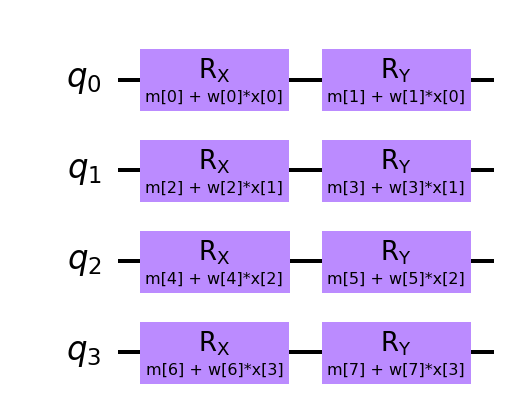

In [38]:
# Define angle embedding with weights


def get_angle_embedding(nb_features, repeat=1):
       
    x_params = ParameterVector('x', nb_features)
    weight_params = ParameterVector('w', 2*nb_features*repeat)
    rotation_params = ParameterVector('m', 2*nb_features*repeat)
    
    model_params = list(rotation_params) + list(weight_params)

    qc = QuantumCircuit(nb_features)
    
    for j in range(repeat):
        for i in range(nb_features):
            qc.rx(x_params[i]*weight_params[2*i+2*nb_features*j] + rotation_params[2*i+2*nb_features*j], i)
            qc.ry(x_params[i]*weight_params[2*i+2*nb_features*j+1] + rotation_params[2*i+2*nb_features*j+1], i)
        
    return qc, x_params, model_params
#
feature_dim = 4
repeat = 1
angle_embedding, x_params, m_params =get_angle_embedding(feature_dim, repeat)

print(x_params)
angle_embedding.draw('mpl',scale=2)


In [11]:
# Define function(s) to generate the encoder circuit
# TODO: implement different designs for data encoding (one function for each)
def encoder_circuit_1(data_x,_):
    """
    Args:
        data_x [np.array] : one data example
        (...)
    Returns:
        encoder_circuit [QuantumCircuit] : encoder circuit for input data example
    """
    encoder_circuit = None
    return encoder_circuit

## 2.2. Prepare Ansatz

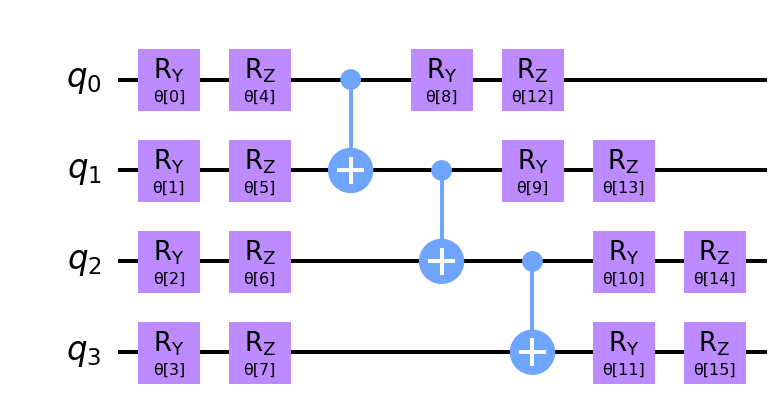

In [16]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(feature_dim, ['ry', 'rz'], 1, 'linear')
ansatz_tl.decompose().draw('mpl', scale=2)

In [17]:
# Define function(s) to generate the ansatz
# TODO: implement different ansatz designs (one function for each)
def ansatz_1(n_qubits,_):
    """
    Args:
        n_qubits [int] : number of qubits in the circuit
        (...other necessary args -- e.g., n_layers)
    Returns:
        ansatz [QuantumCircuit] : parameterized ansatz circuit
        ansatz_params [ParameterVector] : parameter vector of the ansatz
    """
    ansatz = None
    ansatz_params = None
    return ansatz, ansatz_params

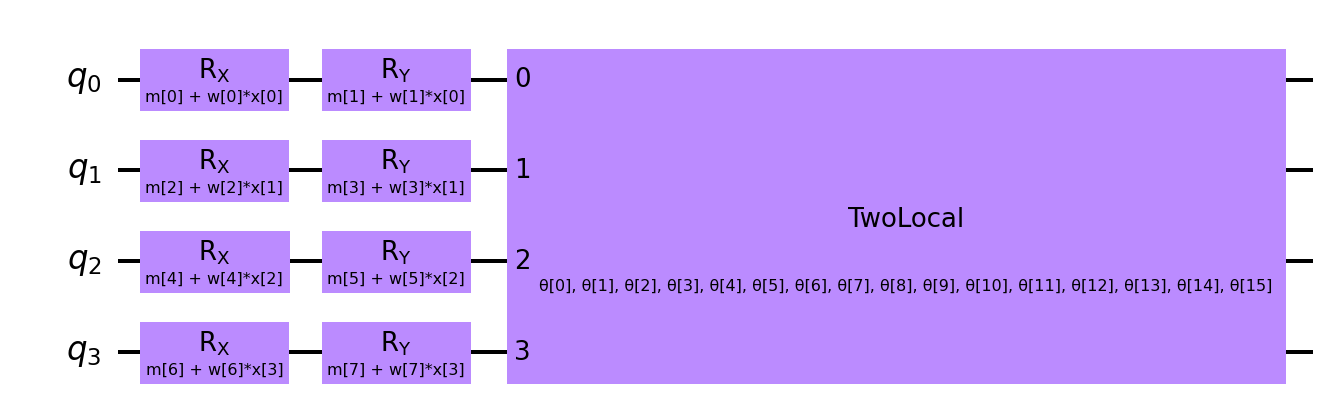

In [39]:
#var_circuit = fmap_zz.compose(ansatz_tl)
#var_circuit = fmap_z.compose(ansatz_tl)

var_circuit = angle_embedding.compose(ansatz_tl)
var_circuit.draw('mpl',scale=2)

In [19]:
# TODO: Define function to generate all data encoder circuits (one for each example in the dataset)
# Preparing and cache all encoder circuits to concatenate with ansatz later
def get_all_encoders(data_mat, encoder_func,_):
    """
    Args:
        data_mat [np.array] : of shape (n_samples,n_features) -- matrix containing all examples
        encoder_func [function] : callable to generate encoder circuit (e.g., encoder_circuit_1)
        (...)
    Returns:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
    """
    all_encoders = []
    # pseudo-code: for 'example' in 'data_mat': all_encoders.append(encoder_func('example'))
    return all_encoders

In [20]:
# TODO: Define function to generate all VQC circuits (one for each example)
def get_all_circuits(all_encoders, ansatz_func, _):
    """
    Args:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
        ansatz_func [function] : callable to generate ansatz circuit (e.g., ansatz_1)
        (...)
    Returns:
        all_circuits [list(QuantumCircuit)] : list of all VQC circuits (one for each example)
    """
    all_circuits = []
    return all_circuits

In [19]:
# Create a quantum instance to wrap the execution of circuits
qinstVQC = QuantumInstance(Aer.get_backend('statevector_simulator'))
# or, real hardware backend qinst = ....

In [22]:
# TODO: Define function to calculate target values (can be expectation value or sampling probability)
def get_all_target_vals(all_results,_):
    """
    Args:
        all_results [Result] : output wrapper of all results from executing the VQC circuits
        (...)
    Returns:
        target_val [list(float)] : target values for classification (e.g., expectation value), one for each example
    """
    target_vals = []
    return target_vals

In [23]:
# TODO: Define function to calculate cost function given all target vals (there can be multiple designs for cost function)
def calculate_cost_function(target_vals,true_labels,_):
    """
    Args:
        target_vals [list(float)] : target values for classification (e.g., expectation value), one for each example
        true_labels [np.array] : vector containing true labels for each example (0 or 1)
        (...)
    Returns:
        cost [float] : total cost for current instance
    """
    cost = 0
    return cost

## 2.3 Prepare measurement

In [20]:
# for multi-class problem this works
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes


# for multi-class problem this needs to be changed
def one_qubit_binary(x):
    return x % 2

## 2.2. Training Implementation

In [21]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP, ADAM

In [ ]:
# TODO: Define training wrapper 
# TODO: Run optimization and plot loss curve
# (...)

## 2.3. Results Discussion

e.g., what method worked best, what did we learn about the problem?

# 3. VQC using Qiskit QNN Classes

In [22]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst_qasm = QuantumInstance(qasm_sim, 2048)

## 3.1. Circuit QNN

In [40]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 #input_params=fmap_z.parameters,
                 #input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                 input_params=x_params,                                  # (e.g. amplitude encoding) you will have to do some extra work!
                 #weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                 weight_params=list(ansatz_tl.parameters)+list(m_params),# parameters of the embedding must be added
                 
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst_qasm)

In [26]:
# to run on hardware
phys_qubits = [3,4,5,6]
N_shots = 2048
qinst_hardware = QuantumInstance(ibmq_jakarta,shots=N_shots,initial_layout=phys_qubits)

NameError: name 'ibmq_jakarta' is not defined

In [44]:
qnn_hardware = CircuitQNN(circuit=var_circuit,
                         #input_params=fmap_z.parameters,
                         #input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                         input_params=x_params,                                  # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=list(ansatz_tl.parameters)+list(m_params),  # if you train your embedding as well, the trainable
                                                              # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=num_classes,
                         gradient=None,
                         quantum_instance=qinst_hardware)

### Forward pass

In [41]:
# The result of the neural network of the shape (output_shape).
weights = np.random.random(len(list(ansatz_tl.parameters)+list(m_params)))

output = qnn.forward(x_train[1], weights )
print(output.shape)
output

(1, 2)


array([[0.76074219, 0.23925781]])

### Backward pass

In [42]:
_, update = qnn.backward(x_train[0], weights)
print(update)
print(update.shape)

[[[-2.82958984e-01 -1.17187500e-02  9.76562500e-04  1.95312500e-03
   -9.66796875e-02 -9.91210938e-02 -4.88281250e-03 -2.92968750e-03
   -3.26416016e-01  9.52148438e-03 -4.88281250e-04 -1.29394531e-02
   -1.14746094e-02  5.85937500e-03 -5.61523438e-03 -2.92968750e-03
   -1.82128906e-01 -2.80273438e-01  1.04492187e-01  1.14746094e-02
   -1.29394531e-02 -9.52148437e-03 -1.22070312e-03  1.04980469e-02
    2.62444093e-02  4.06805864e-02  4.74479055e-02  1.74120754e-03
    3.27723597e-03  4.05753025e-03  2.28470837e-04  4.45518132e-03]
  [ 2.82958984e-01  1.17187500e-02 -9.76562500e-04 -1.95312500e-03
    9.66796875e-02  9.91210938e-02  4.88281250e-03  2.92968750e-03
    3.26416016e-01 -9.52148438e-03  4.88281250e-04  1.29394531e-02
    1.14746094e-02 -5.85937500e-03  5.61523437e-03  2.92968750e-03
    1.82128906e-01  2.80273438e-01 -1.04492188e-01 -1.14746094e-02
    1.29394531e-02  9.52148438e-03  1.22070312e-03 -1.04980469e-02
   -2.62444093e-02 -4.06805864e-02 -4.74479055e-02 -1.7412075

### 3.1.1. Prepare encoder, ansatz, and interpreter

In [31]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [31]:
print(y_train[0])
print(y_train_1h[0])

print(y_train[4])
print(y_train_1h[4])

1.0
[0. 1.]
0.0
[1. 0.]


In [32]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

### 3.1.2. Training Implementation

In [43]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(list(ansatz_tl.parameters)+list(m_params)),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(), #log of ...
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train]) # normalizing or not ... can depend on the data set you can try both

vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 104.95572624538704
6 - 106.8005273190532
9 - 104.36097846369742
12 - 104.59777448746816
15 - 104.51206330182715
18 - 104.63521870447848
21 - 104.36940659510611
24 - 101.91796255885546
27 - 110.51672756817635
30 - 112.29148373810817
33 - 111.54661929758174
36 - 102.87482263305289
39 - 102.84990823683692
42 - 102.7299057053797
45 - 101.77573431012325
48 - 101.85617493254276
51 - 101.33526176306741
54 - 101.57767754057507
57 - 101.2196643245142
60 - 101.1938787482513
63 - 101.06172043386522
66 - 99.75494414810335
69 - 100.58216297361994
72 - 100.31976443026461
75 - 99.69574135212484
78 - 99.10404203046087
81 - 99.32530778337318
84 - 98.31593034469057
87 - 98.89480573162068
90 - 98.4257556602598
93 - 98.46876325637874
96 - 98.64030233483922
99 - 98.44201570875458
102 - 98.3166161588404
105 - 98.74568464469668
108 - 98.48878046728726
111 - 98.75342805415282
114 - 98.6081075182668
117 - 98.35512177470044
120 - 98.41737370721943
123 - 98.29317345248272
126 - 98.77783936994489
129 - 97.922

In [ ]:
# to run on hardware
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(list(ansatz_tl.parameters)+list(m_params)),))
vqc = NeuralNetworkClassifier(neural_network=qnn_hardware,
                              loss=CrossEntropyLoss(), #log of ...
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train]) # normalizing or not ... can depend on the data set you can try both

vqc = vqc.fit(x_train_norm, y_train_1h)

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\qiskit\utils\run_circuits.py:727: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)


In [44]:
score_train_norm = vqc.score(x_train_norm, y_train_1h)
print(f'Score on the normalized train set {score_train_norm}')

x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test]) # normalizing or not ... can depend on the data set you can try both
score_test_norm = vqc.score(x_test_norm, y_test_1h)
print(f'Score on the normalized test set {score_test_norm}')

Score on the normalized train set 0.52
Score on the normalized test set 0.604


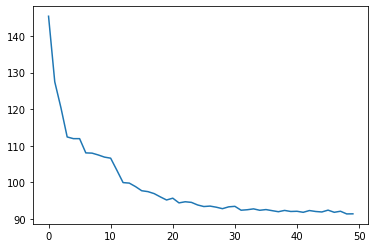

In [37]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

## 3.2. Opflow QNN

### 3.2.1. Define measurement operator and circuit state function

In [64]:
from qiskit.opflow import StateFn, Gradient, I, Z

In [65]:
obs_parity = Z ^ feature_dim
obs_one_qubit = I ^ (feature_dim - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIZ'), coeff=1.0)

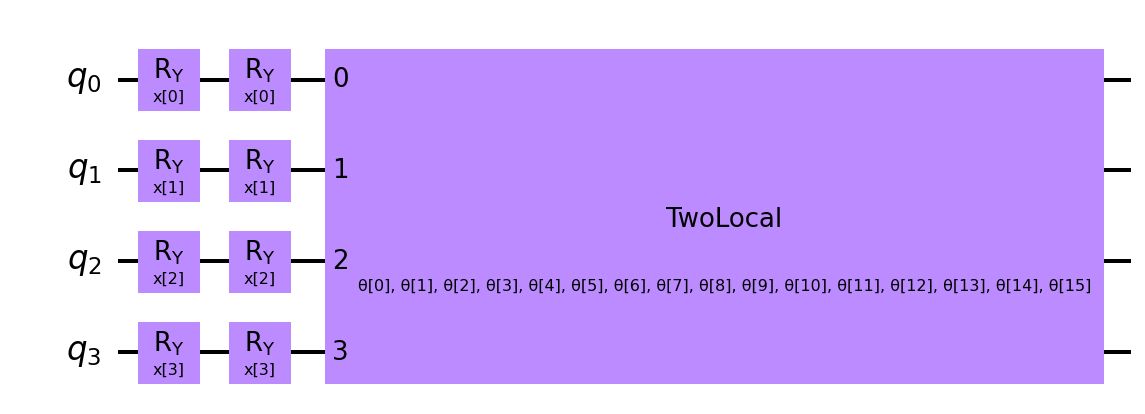

In [66]:
#fmap_z_op = get_z_feature_map(feature_dim, 3)
#var_circuit_op = fmap_z_op.compose(ansatz_tl)

#fmap_zz_op = get_zz_feature_map(feature_dim, 3)
#var_circuit_op = fmap_zz_op.compose(ansatz_tl)

mymap_op = get_my_map(feature_dim, 2)
var_circuit_op = mymap_op.compose(ansatz_tl)


var_circuit_op.draw('mpl',scale=2)

In [67]:
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit_op)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002034FA53610>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [68]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(operator,
                   #input_params=fmap_z_op.parameters,
                   input_params=mymap_op.parameters,
                   weight_params=ansatz_tl.parameters,
                   gradient=gradient,
                   quantum_instance=qinst_qasm)

### Forward pass

In [69]:
weights = np.random.random(len(ansatz_tl.parameters))
output = op_qnn.forward(x_train[0], weights)
print(output.shape)

(1, 1)


### Backward pass

In [64]:
_, update = op_qnn.backward(x_train[0], weights)
print(update.shape)
update

(1, 1, 16)


array([[[-0.46582031, -0.00732422, -0.00390625,  0.01757813,
          0.04003906,  0.00878906, -0.01855469,  0.00830078,
         -0.83789062,  0.02880859,  0.00732422,  0.01318359,
         -0.00683594, -0.01318359, -0.00244141, -0.01220703]]])

### 3.1.2. Training Implementation

In [70]:
from qiskit.algorithms.optimizers import GradientDescent

In [71]:
y_train_pm = np.array([-1 if y==0 else y for y in y_train])
y_test_pm = np.array([-1 if y==0 else y for y in y_test])
y_train.shape

(80,)

In [72]:
max_itr = 30
gd_opt = GradientDescent(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
op_vqc = NeuralNetworkClassifier(neural_network=op_qnn,
                                 loss=L2Loss(),
                                 one_hot=False,
                                 optimizer=gd_opt,
                                 initial_point=initial_point)

op_vqc = op_vqc.fit(x_train, y_train_pm)

1 - 109.27603054046631
2 - 108.25804901123047
3 - 106.33079814910889
4 - 104.87362766265869
5 - 101.9281587600708
6 - 97.71057415008545
7 - 90.23495197296143
8 - 83.41075992584229
9 - 80.60181045532227
10 - 79.26840400695801
11 - 79.95791816711426
12 - 80.30300807952881
13 - 80.20854091644287
14 - 79.80421257019043
15 - 79.60912609100342
16 - 79.73513221740723
17 - 79.49081230163574
18 - 79.88297939300537
19 - 79.32025814056396
20 - 80.02000522613525
21 - 79.58462333679199
22 - 78.97389793395996
23 - 79.08813285827637
24 - 79.29561614990234
25 - 79.15980339050293
26 - 79.86717987060547
27 - 78.74774742126465
28 - 79.38510417938232
29 - 78.82346248626709
30 - 79.52055835723877


In [73]:
score_train = op_vqc.score(x_train, y_train_pm)
score_test = op_vqc.score(x_test, y_test_pm)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5125
Score on the test set 0.65


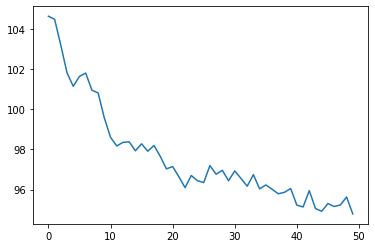

In [36]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

# 4. Quantum Support Vector Machine (if have time)

## 4.1. Define feature map(s) (kernel)

In [39]:
qinst_kernel = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))

In [21]:
# ZZ-featureMap
def ZZ_kernel(feature_dim,reps,quantum_instance,entanglement='linear',insert_barriers=False):
    ZZ_map = ZZFeatureMap(feature_dimension=feature_dim,reps=reps,entanglement=entanglement,insert_barriers=insert_barriers)
    ZZ_kernel = QuantumKernel(ZZ_map,quantum_instance=quantum_instance)
    return ZZ_kernel

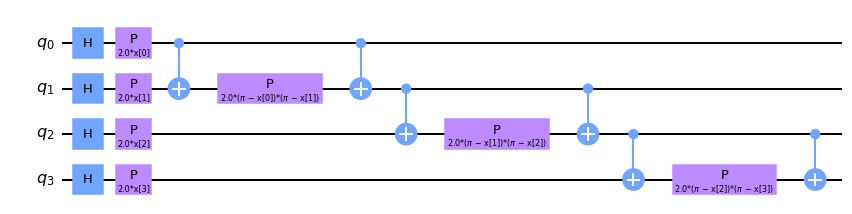

In [27]:
kernel = ZZ_kernel(feature_dim,reps=1,quantum_instance=qinst_kernel)
kernel.feature_map.decompose().draw('mpl')

In [36]:
# custom kernel inspired by Xiaoran's design, with linear entanglement
def custom_kernel(feature_dim,reps,quantum_instance,insert_barriers=False):
    qc = QuantumCircuit(feature_dim)
    data_params = ParameterVector('x',feature_dim)
    for layer in range(reps):
        for i in range(feature_dim):
            qc.ry(data_params[i],i)
            qc.rz(data_params[i],i)
        for i in range(feature_dim-1):
            qc.cx(i,i+1)
        if insert_barriers: qc.barrier() 
    kernel = QuantumKernel(feature_map=qc,quantum_instance=quantum_instance)
    return kernel

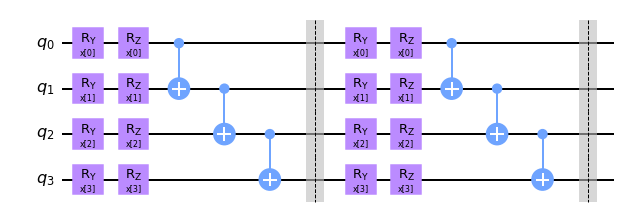

In [37]:
my_kernel = custom_kernel(feature_dim=feature_dim,reps=2,quantum_instance=qinst_kernel,insert_barriers=True)
my_kernel.feature_map.draw('mpl')

## 4.2. Training Implementation (using sci-kit's SVC class)

### 4.2.1. Training with ZZ-FeatureMap

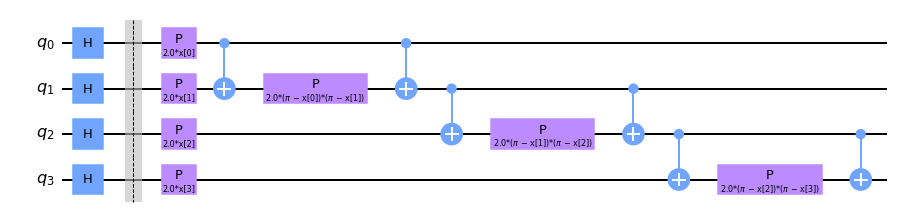

In [213]:
kernel_ZZ = ZZ_kernel(feature_dim=feature_dim,reps=1,quantum_instance=qinst_kernel,insert_barriers=True)
display(kernel_ZZ.feature_map.decompose().draw('mpl'))

In [214]:
qclf_ZZ = svm.SVC(kernel=kernel_ZZ.evaluate)

In [215]:
qclf_ZZ.fit(x_train_norm,y_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000019FFC4E8D90>>)

In [216]:
print(f'Training accuracy: {qclf_ZZ.score(x_train_norm,y_train)}')

Training accuracy: 0.815


In [217]:
print(f'Test accuracy: {qclf_ZZ.score(x_test_norm,y_test):.3f}')

Test accuracy: 0.727


### 4.2.2. Training with custom feature map

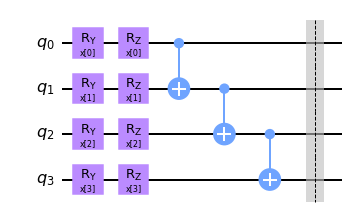

In [191]:
kernel_custom = custom_kernel(feature_dim=feature_dim,reps=1,quantum_instance=qinst_kernel,insert_barriers=True)
display(kernel_custom.feature_map.draw('mpl'))

In [192]:
qclf_custom = svm.SVC(kernel=kernel_custom.evaluate)

In [193]:
qclf_custom.fit(x_train_norm,y_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000019FFBDDDFA0>>)

In [194]:
print(f'Training accuracy: {qclf_custom.score(x_train_norm,y_train):.3f}')

Training accuracy: 0.700


In [195]:
print(f'Test accuracy: {qclf_custom.score(x_test_norm,y_test):.3f}')

Test accuracy: 0.744


## 4.3. Results Discussion

# 5. Classical Methods (if have time)

## 5.1. Classical SVM

In [210]:
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(x_train_norm,y_train)
print(f'Training accuracy: {clf_linear.score(x_train_norm,y_train):.3f}\n'+
        f'Testing accuracy: {clf_linear.score(x_test_norm,y_test):.3f}')

Training accuracy: 0.761
Testing accuracy: 0.761


In [211]:
clf_poly = svm.SVC(kernel='poly',degree=3)
clf_poly.fit(x_train_norm,y_train)
print(f'Training accuracy: {clf_poly.score(x_train_norm,y_train):.3f}\n'+
        f'Testing accuracy: {clf_poly.score(x_test_norm,y_test):.3f}')

Training accuracy: 0.678
Testing accuracy: 0.690


In [212]:
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(x_train_norm,y_train)
print(f'Training accuracy: {clf_rbf.score(x_train_norm,y_train):.3f}\n'+
        f'Testing accuracy: {clf_rbf.score(x_test_norm,y_test):.3f}')

Training accuracy: 0.786
Testing accuracy: 0.773


## 5.2. Classical Neural Network

In [89]:
from sklearn.neural_network import MLPClassifier

### 5.2.1. ANN w/ 1 Hidden Layer (20) -- ReLU activation

In [230]:
clf_nn = MLPClassifier(solver='adam', hidden_layer_sizes = (20,), learning_rate='adaptive', random_state=1, max_iter=10000)
clf_nn.fit(x_train_norm,y_train)
print(f'Converged after {clf_nn.n_iter_} iterations')

Converged after 278 iterations


In [231]:
print(f'Training accuracy: {clf_nn.score(x_train_norm,y_train):.3f}\n'+
        f'Testing accuracy: {clf_nn.score(x_test_norm,y_test):.3f}')

Training accuracy: 0.780
Testing accuracy: 0.778


### 5.2.2. ANN w/ 2 Hidden Layers (20,20) -- ReLU activation

In [232]:
clf_nn_2 = MLPClassifier(solver='adam', hidden_layer_sizes = (20,20), learning_rate='adaptive', random_state=1, max_iter=10000)
clf_nn_2.fit(x_train_norm,y_train)
print(f'Converged after {clf_nn_2.n_iter_} iterations')

Converged after 1040 iterations


In [233]:
print(f'Training accuracy: {clf_nn_2.score(x_train_norm,y_train):.3f}\n'+
        f'Testing accuracy: {clf_nn_2.score(x_test_norm,y_test):.3f}')

Training accuracy: 0.833
Testing accuracy: 0.811


### 5.2.3. ANN w/ 1 Hidden Layer (20) -- Sigmoid activation

In [234]:
clf_nn_sig = MLPClassifier(solver='adam', activation='logistic', hidden_layer_sizes = (20,), learning_rate='adaptive', random_state=1, max_iter=10000)
clf_nn_sig.fit(x_train_norm,y_train)
print(f'Converged after {clf_nn_sig.n_iter_} iterations')

Converged after 274 iterations


In [235]:
print(f'Training accuracy: {clf_nn_sig.score(x_train_norm,y_train):.3f}\n'+
        f'Testing accuracy: {clf_nn_sig.score(x_test_norm,y_test):.3f}')

Training accuracy: 0.787
Testing accuracy: 0.777


### 5.2.2. ANN w/ 2 Hidden Layers (20,20) -- Sigmoid activation

In [236]:
clf_nn_sig_2 = MLPClassifier(solver='adam',activation='logistic', hidden_layer_sizes = (20,20), learning_rate='adaptive', random_state=1, max_iter=10000)
clf_nn_sig_2.fit(x_train_norm,y_train)
print(f'Converged after {clf_nn_sig_2.n_iter_} iterations')

Converged after 170 iterations


In [237]:
print(f'Training accuracy: {clf_nn_sig_2.score(x_train_norm,y_train):.3f}\n'+
        f'Testing accuracy: {clf_nn_sig_2.score(x_test_norm,y_test):.3f}')

Training accuracy: 0.784
Testing accuracy: 0.776


# 6. Summary & Conclusion

Summarize and reflect on all aspects and observations of the project. Did we end up with a decent classifier?